# Projeto 2 - NLP Análise de Sentimento

-----


<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQl_uVVki1hENn7Ov86KtGFX1aPwUWc7cD83Q&usqp=CAU" width=600 >

## Os Dados

Utilizaremos um dataset obtido no Twitter, com 100K postagens realizadas entre os dias 01/08/2018 e 20/10/2018. Sendo que cada postagem é classificada como **positiva**, **negativa** ou **neutra**.  

Descrição das colunas:

- **id**: ID único para o tweet  
- **tweet_text**: Texto da publicação no Twitter  
- **tweet_date**: Data da publicação no Twitter  
- **sentiment**: 0, se negativo; 1, se positivo; 2, se neutro  
- **query_used**: Filtro utilizado para buscar a publicação

## O Problema

Desenvolver um modelo para detectar o sentimento de uma publicação do Twitter, a classificando em uma das três categorias: **positiva**, **negativa** ou **neutra**. O texto da publicação está disponível na coluna "tweet_text". Serão testadas pelo menos 2 técnicas de NLP diferentes, sendo escolhida a métrica de avaliação mais pertinente.  



# Índice

1. [Ferramentas](#1.-Ferramentas)

    1.1 [Importando as bibliotecas](#1.1-Importando-as-bibliotecas)
     
    1.2 [Funções auxiliares](#1.2-Funções-auxiliares)
    

2. [EDA](#2.-EDA)

  
3. [Preprocessando o dataset](#3.-Preprocessando-o-dataset)

 
4. [Modelos](#4.-Modelos)

    4.1 [Modelo MultinomialNB](#4.1-Modelo-MultinomialNB)

    4.2 [Modelo de Rede Neural](#4.2.1-Modelo-de-Rede-Neural)

      4.2.1 [Aplicando o modelo nos dados de teste](#4.2.2-Aplicando-o-modelo-nos-dados-de-teste)

   

# 1. Ferramentas

## 1.1 Importando as bibliotecas

In [56]:
import numpy as np
import pandas as pd
import re
import emoji
import unidecode
import spacy
import matplotlib.pyplot as plt
import warnings

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold

from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings('ignore')

In [2]:
# Downloads dos pacotes
nltk.download('stopwords')
nltk.download('punkt')  
nltk.download('rslp')
words_pt = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vajja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vajja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\vajja\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## 1.2 Funções auxiliares

In [18]:
def preprocessing(string):
    
    # retira os emojis
    string = emoji.replace_emoji(string, replace='').lower()
    
    # retira os links
    url_pattern = r'[a-zA-Z0-9]+://[a-zA-Z0-9.-_]+/[a-zA-Z0-9]+'
    string = re.sub(url_pattern,'', string)
    
    # retira os referecias de usuários
    pattern = r'@[a-zA-Z0-9_.]+'
    string = re.sub(pattern,'', string)
    
    # retira as palavras chaves para a busca dos dados neutros
    string = re.sub('#fato|#novidade|#noticia|#curiosidade|#oportunidade|#trabalho','', string)    
    
    # retira a acentuação
    string = unidecode.unidecode(string)
    
    # retira os carcteres especiais e padroniza em letras minúsculas
    string = re.sub(r'[^a-zA-Z0-9]+',' ', string).lower()
    
    # aplicando a tokenização
    words = word_tokenize(string)    
    
    # removendo as stopwords
    words_pt = nltk.corpus.stopwords.words('portuguese')
    
    filtered_words = [w for w in words if w not in words_pt]
    
    # aplicando a Lemmatization
    new_string = " ".join(filtered_words)
    
    nlp = spacy.load("pt_core_news_sm")
    doc = nlp(new_string)
    tokens = [token for token in doc]
    
    lemmatized_sentence = [token.lemma_ for token in doc]
    
    #retornando a lista de palavras
    return lemmatized_sentence
               
def trasnform_texto(string):
    string = re.sub(r'[^a-zA-Z0-9]+',' ', string)
    return string

def trasnform_token(string):
    return word_tokenize(string) 

def avaliacao(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "r", label="Treino acc")
    plt.plot(epochs, val_accuracy, "b", label="Val acc")
    plt.xlabel("Épocas")
    plt.ylabel("%s")
    plt.title("Acurácia de Treino e Validação")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "r", label="Treino loss")
    plt.plot(epochs, val_loss, "b", label="Val loss")
    plt.xlabel("Épocas")
    plt.ylabel("%s")
    plt.title("Loss de Treino e Validação")
    plt.legend()
    return plt.show()

def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)
    
    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train,cmap='cividis')
    plt.show()

    print(classification_report(y_train, y_pred_train))
    
    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,cmap='cividis')
    plt.show()

    print(classification_report(y_test, y_pred_test))
    
def reducao_palavras(x,dicionario):
    text = []
    for i in x:
        if i in dicionario[dicionario>15].index:
            text.append(i)
    return text            

# 2. EDA

In [4]:
# Lendo a base inicial
df = pd.read_csv('./Dados/train/Train3Classes.csv')

In [5]:
# Tamanhdo do dataset
df.shape

(95000, 5)

In [6]:
# Primeiras informações
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          95000 non-null  int64 
 1   tweet_text  95000 non-null  object
 2   tweet_date  95000 non-null  object
 3   sentiment   95000 non-null  int64 
 4   query_used  95000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


In [7]:
# Qual é o balanceamento das classes a serem preditas
df['sentiment'].value_counts()

0    31696
1    31678
2    31626
Name: sentiment, dtype: int64

In [9]:
# Visualização de 10 feaures que será usada para predição 
for i in range(0,200,20):
    
    print(df['tweet_text'].iloc[i],' ----- ', df['query_used'].iloc[i],'\n\n')

Rio elege maior bancada policial de sua história https://t.co/sGXnhZKrHx https://t.co/Mcgiz70jPF  -----  folha 


@DiorFgomes @Teledramaturgia Exato! Minha pergunta era sobre pessoas normais e não deusas como Alcione. :)  -----  :) 


@diegutrembala meu amooooor q sdd :( quase nem to indo pra votu  -----  :( 


ai to precisando de colo :(  -----  :( 


eu te amo :( https://t.co/w96VEsULVD  -----  :( 


td q eu queria: ir pra porto e com o theo :( https://t.co/6DvfXK24eI  -----  :( 


@_GustvoSilveira af num importa eu sei a história ain :(  -----  :( 


Não consegui :( mais uma chance que eu perco por auto sabotagem  -----  :( 


@eduardissimo Tudo dela desde i don't Want it at all tem. Mas o contrato dela com ele foi firmado antes do escândalo todo, eu acho. :(  -----  :( 


tão queridas as nossas primeiras conversas, nem parecia q eu ia sofrer como sofro hj :)  -----  :) 




In [13]:
# Linhas duplicadas
df[['tweet_text','sentiment',]].duplicated().sum()

815

É possível perceber que não existem dados faltantes e que apenas as colunas ID e SENTIMENT são numéricas.

É visível que a classe à qual se deseja predizer encontra-se balanceada, sem necessidade de ajustes.

Avaliando a coluna tweet_text, pode-se notar que existem vários emojis e pontuações expressando sentimentos, como, por exemplo, o rosto triste representado por " :( " , percebe-se menções por meio do " @ " , do " # " e de urls.

O mais importante a se destacar é que a coluna tweet_text contém a variável resposta, ou seja, sempre que há um emoji triste " :( " a coluna sentiment é 0, de forma analoga o emoji " :) " a resposta é o 1, bem como onde há urls e '#fato', '#novidade', '#noticia', '#curiosidade', '#oportunidade' e '#trabalho' a resposta é 2. Isso se deve ao fato de como a base de dados foi construída por meio da coluna query_used, que usou como filtro os emojis para selecionar os dados.

Portanto, para a construção de um modelo é indispensável a retirada da sinalização utilizada para filtragem de dados, caso contrário existirá um vazamento de dados que prejudicará o modelo.


# 3. Pré-processando o dataset

In [14]:
# Removendo as linhas duplicadas
df = df[['tweet_text','sentiment',]].drop_duplicates()

In [21]:
# Pre-processamento 
df['new_text'] = df['tweet_text'].apply(preprocessing)
df['join_text'] = df['new_text'].apply(lambda x: ' '.join(x))

#Salvando o dataset já processado
df.to_csv('data3.csv',index=False) 

In [22]:
# Lendo o dataset processado 
df = pd.read_csv('data3.csv')

In [25]:
# 5 primeiras linhas
df.head()

,tweet_text,sentiment,new_text,join_text
0,Rio elege maior bancada policial de sua histór...,2,"['rio', 'eleger', 'grande', 'bancada', 'polici...",rio eleger grande bancada policial historio
1,fiquei tão triste quando eu vi o preço da câme...,0,"['fiquei', 'tao', 'triste', 'ver', 'precor', '...",fiquei tao triste ver precor camer
2,"Para Theresa May, seu plano para o Brexit é a ...",2,"['thereso', 'may', 'plano', 'brexit', 'unico',...",thereso may plano brexit unico opcao
3,caralho eu quero proteger a danielly em um pot...,0,"['caralho', 'querer', 'proteger', 'danielly', ...",caralho querer proteger danielly pote tadinhaa
4,@SiCaetano_ viva o caos :),1,"['viver', 'caos']",viver caos


In [26]:
# Ajustando os dados
df['join_text'] = df['new_text'].apply(trasnform_texto)

df['new_text'] = df['join_text'].apply(trasnform_token)

In [27]:
# Verficação das palavras menos e mais frequentes
palavras = pd.DataFrame(np.concatenate(df['new_text'].values), columns = ['palavras'])
dicionario = palavras.groupby('palavras').size().sort_values()
dicionario

palavras
glote                1
ismo                 1
isnr                 1
isntazinho           1
isolacionismo        1
                 ...  
ver               5511
querer            6368
pra               7137
ir               10640
nao              18010
Length: 59242, dtype: int64

In [28]:
df['text'] = df['new_text'].apply(lambda x: reducao_palavras(x,dicionario))

In [29]:
df.head()

,tweet_text,sentiment,new_text,join_text,text
0,Rio elege maior bancada policial de sua histór...,2,"[rio, eleger, grande, bancada, policial, histo...",rio eleger grande bancada policial historio,"[rio, eleger, grande, bancada, policial, histo..."
1,fiquei tão triste quando eu vi o preço da câme...,0,"[fiquei, tao, triste, ver, precor, camer]",fiquei tao triste ver precor camer,"[fiquei, tao, triste, ver, precor]"
2,"Para Theresa May, seu plano para o Brexit é a ...",2,"[thereso, may, plano, brexit, unico, opcao]",thereso may plano brexit unico opcao,"[may, plano, brexit, unico, opcao]"
3,caralho eu quero proteger a danielly em um pot...,0,"[caralho, querer, proteger, danielly, pote, ta...",caralho querer proteger danielly pote tadinhaa,"[caralho, querer, proteger, pote]"
4,@SiCaetano_ viva o caos :),1,"[viver, caos]",viver caos,"[viver, caos]"


# 4. Modelos

## 4.1 Modelo MultinomialNB

In [40]:
# Transformando os dados
df['join_text2'] = df['text'].apply(lambda x: ' '.join(x))

In [41]:
# Separando em treino e teste
X = df['join_text2']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify=y)



In [45]:
# Instanciando o transformador
tfidf = TfidfVectorizer(use_idf = True,)

# Transforma os dados nas matrizes de saída
X_train_tfidf = tfidf.fit_transform(X_train).todense()
X_test_tfidf  = tfidf.transform(X_test).todense()

In [48]:
# Instanciando o modelo
model = MultinomialNB()

# treinamento do modelo
model.fit(X_train_tfidf, y_train)

MultinomialNB()


Métricas de avaliação de treino:


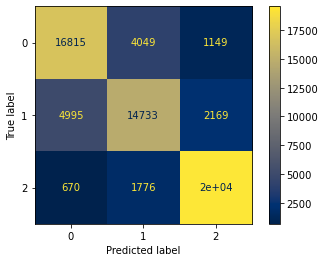

              precision    recall  f1-score   support

           0       0.75      0.76      0.76     22013
           1       0.72      0.67      0.69     21897
           2       0.86      0.89      0.87     22019

    accuracy                           0.78     65929
   macro avg       0.77      0.78      0.77     65929
weighted avg       0.77      0.78      0.77     65929


Métricas de avaliação de teste:


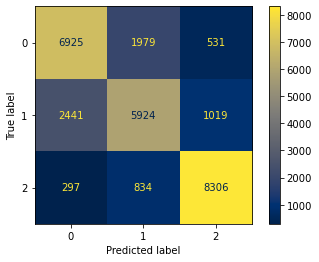

              precision    recall  f1-score   support

           0       0.72      0.73      0.73      9435
           1       0.68      0.63      0.65      9384
           2       0.84      0.88      0.86      9437

    accuracy                           0.75     28256
   macro avg       0.75      0.75      0.75     28256
weighted avg       0.75      0.75      0.75     28256



In [52]:
# Avaliação do modelo
metricas_classificacao(model, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [57]:
#Ajuste do Modelo
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__fit_prior': (True, False),
              'clf__alpha': (0.2, 0.5, 0.7, 1.0)}

splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
gs_clf = GridSearchCV(text_clf, parameters, cv=splitter ,n_jobs=-1, scoring="f1_weighted")
gs_clf.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.2, 0.5, 0.7, 1.0),
                         'clf__fit_prior': (True, False),
                         'tfidf__use_idf': (True, False),
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_weighted')

In [58]:
# Visualização dos melhores parâmetros
gs_clf.best_params_

{'clf__alpha': 0.2,
 'clf__fit_prior': False,
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 2)}


Métricas de avaliação de treino:


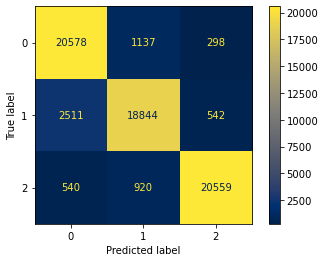

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     22013
           1       0.90      0.86      0.88     21897
           2       0.96      0.93      0.95     22019

    accuracy                           0.91     65929
   macro avg       0.91      0.91      0.91     65929
weighted avg       0.91      0.91      0.91     65929


Métricas de avaliação de teste:


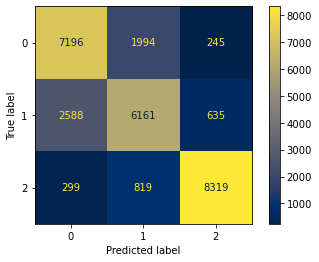

              precision    recall  f1-score   support

           0       0.71      0.76      0.74      9435
           1       0.69      0.66      0.67      9384
           2       0.90      0.88      0.89      9437

    accuracy                           0.77     28256
   macro avg       0.77      0.77      0.77     28256
weighted avg       0.77      0.77      0.77     28256



In [59]:
#Avaliação do modelo
metricas_classificacao(gs_clf, X_train, X_test, y_train, y_test)

## 4.2.1 Modelo de Rede Neural

In [ ]:
# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(df['new_text'],
                                                    df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=42)

In [160]:
# Separando os dados em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.1,
                                                  random_state=42)

In [167]:
# Estabelecendo limites
vocab_size = 20000
embedding_dim = 16
max_length = 250

In [176]:
# Fazendo a tokenização
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

In [177]:
# Fazendo ajuste dos dados
padded = pad_sequences(sequences,maxlen=max_length)
val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(val_sequences,maxlen=max_length)
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences,maxlen=max_length)

In [178]:
# Instanciando o modelo
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(50, activation = "relu"))
model.add(Dense(10))
model.add(Dense(3))
model.add(Activation('softmax'))

In [179]:
# Metricas de aprendizado
model.compile(optimizer = "adam",
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

In [180]:
# Treinando o modelo
callbacks = [
    ModelCheckpoint(
        filepath="modelo1.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
results = model.fit(
 padded, y_train,
 epochs=5,
 batch_size = 64,
 validation_data = (val_padded, y_val),
 callbacks=callbacks)

Epoch 1/5
1060/1060 [==============================] - 11s 9ms/step - loss: 0.6328 - accuracy: 0.6979 - val_loss: 0.4866 - val_accuracy: 0.7855
Epoch 2/5
1060/1060 [==============================] - 10s 9ms/step - loss: 0.4122 - accuracy: 0.8235 - val_loss: 0.4730 - val_accuracy: 0.7973
Epoch 3/5
1060/1060 [==============================] - 10s 9ms/step - loss: 0.3278 - accuracy: 0.8648 - val_loss: 0.5039 - val_accuracy: 0.7918
Epoch 4/5
1060/1060 [==============================] - 10s 9ms/step - loss: 0.2659 - accuracy: 0.8941 - val_loss: 0.5632 - val_accuracy: 0.7861
Epoch 5/5
1060/1060 [==============================] - 10s 10ms/step - loss: 0.2168 - accuracy: 0.9129 - val_loss: 0.6381 - val_accuracy: 0.7800


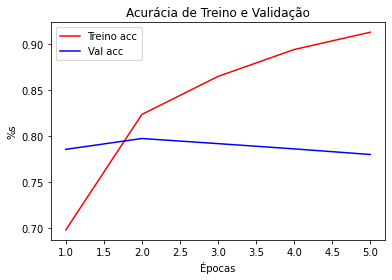

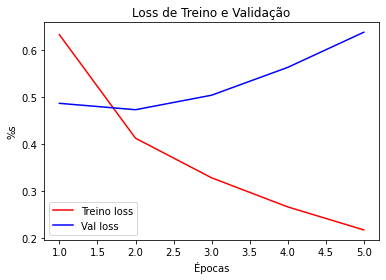

In [181]:
# Avaliação do treino
avaliacao(results)

## 4.2.2 Aplicando o modelo nos dados de teste

In [182]:
# Carregando o melhor modelo
model = load_model("modelo1.keras")

# Aplicando os dados de teste no modelo e verificando sua performace 
test_loss, test_acc = model.evaluate(test_padded,y_test)
print(f"Test accuracy: {test_acc:.3f}")

589/589 [==============================] - 1s 2ms/step - loss: 0.4883 - accuracy: 0.7909
Test accuracy: 0.791


# Conclusão

Nas análises realizadas foi possível desenvolver um modelo para detectar o sentimento de uma publicação do Twitter, sendo que os modelos apresentaram bom desempenho. Foram testadas duas técnicas de NLP diferentes, a Rede Neural e a MultinomialNB. A primeira apresentou um  desempenho com uma acurácia de 79,1% de acerto, enquanto a segunda apresentou 77% de acurácia. Estes resultados indicam que é possível extrair a análise de sentimento através dos dados, porém é necessário entender qual é o contexto em que o modelo será aplicado, uma vez que a escrita e o linguajar são diferentes; apesar de ser uma só lingua, uma análise no contexto do Tweeter requer um preprocessameno muito difente de uma análise no contexto jurídico, por exemplo.